# 와인 감별사 : 와인의 Quality를 분류하는 Classifier 만들기

## 1. 과제 설명
이번 과제에서는 케라스(Keras)를 활용하여, 와인의 품질을 분류하는 인공신경망 분류기를 만들어 볼 것입니다.
케라스는 Tensorflow, Theano 등의 딥 러닝 라이브러리 위에서 동작하는 오픈 소스 라이브러리로, 보다 쉬운 API를 제공함으로써 모델 설계 및 학습, 테스트가 간단하다는 장점이 있습니다. 

### 1.1 케라스 설치를 위한 필수 라이브러리
케라스를 설치하기 전에 먼저 필수적으로 설치해야 할 것들이 있습니다.
* Anaconda : Python 3.x 버전, Numpy, Pandas, SciPy, sklearn 등 필수 라이브러리들이 포함된 통합 배포 팩
<br> 아나콘다 설치 : https://www.anaconda.com/distribution/#download-section
* Tensorflow : Google에서 개발한 오픈 소스 딥 러닝 라이브러리. <b>설치된 Python 버전과 호환되는 것으로 설치할것!</b>
<br> 텐서플로우 설치 : https://www.tensorflow.org/install/pip
<br> * CPU 버전을 설치할 것을 권장. 

### 1.2 케라스 설치
위 라이브러리들을 설치한 후, 케라스를 설치합니다.
* https://keras.io/#installation

### 1.3 케라스 설치 확인
케라스가 올바르게 설치되었는지 확인하기 위해, 케라스를 Import한 뒤 버전을 출력해봅니다.


In [1]:
from tensorflow import keras

keras.__version__

'2.4.0'

위와 같이 케라스의 버전이 출력되면 정상입니다. (출력되는 버전은 위 예시와 다를 수도 있음)<br> 나중에 신경망을 만들기 위한 클래스들도 함께 Import 합시다.

In [12]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from keras.layers.normalization import BatchNormalization

---
## 2. Data Set 설명
 본 과제에서 사용할 데이터 셋은 UCI에서 제공되는 Wine Quality Data Set입니다. (https://archive.ics.uci.edu/ml/datasets/Wine+Quality) 데이터는 레드 와인 1599개, 화이트 와인 4898개의 화학적 특성을 포함하고 있습니다. 데이터는 두 개의 CSV(Comma-seperated values)형태로 제공되며, 구성은 다음과 같습니다.
* 화이트 와인 / 레드 와인 CSV 파일
* 11개의 실수(Real) 입력 변수 (X)
    * fixed acidity
    * volatile acidity
    * citric acid
    * residual sugar
    * chlorides
    * free sulfur dioxide
    * total sulfur dioxide
    * density
    * pH
    * sulphates
    * alcohol
* 1개의 클래스 레이블 (Y)
   * quality (0~10, 0: Very poor, 10: Very excellent)
* Missing Value 없음
* 클래스들이 불균등하게 분포함.

더 자세한 사항은 블랙보드에 함께 올라가있는 설명 파일을 참고하도록 합시다.

### 2.1 데이터 로드
데이터 분석에서 가장 많이 사용되는 라이브러리 중 하나인 Pandas와 Numpy를 Import하겠습니다. Pandas는 데이터 분석에 유용한 데이터 타입인 DataFrame을 제공하며, Numpy는 효율적이고 빠른 매트릭스 연산을 지원합니다.

In [4]:
import pandas as pd
pd.__version__
pd.options.display.max_rows=15

In [5]:
import numpy as np
np.__version__

'1.19.5'

Pandas를 이용해서 CSV 파일을 읽어들이도록 합시다. white_wine 변수에는 화이트 와인 데이터를, red_wine 변수에는 레드 와인 데이터를 읽어들입니다.

In [6]:
import pandas as pd

white_wine = pd.read_csv('winequality-white.csv', header='infer')
red_wine = pd.read_csv('winequality-red.csv', header='infer')

### 2.2 데이터 전처리
데이터를 읽어들인 뒤, 읽어들인 데이터프레임을 display 함수를 통해 확인합니다.

In [7]:
display(white_wine)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [8]:
display(red_wine)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11,34,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25,67,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15,54,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17,60,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11,34,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32,44,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39,51,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32,44,0.99547,3.57,0.71,10.2,5


이제 데이터프레임을 입력 변수와 정답 셋(클래스 레이블)으로 나누는 함수를 작성하겠습니다.<br>
<b>generate_data</b>함수는 데이터프레임 객체와 테스트 셋 비율을 입력으로 받아, 네 개의 numpy array를 반환합니다. 트레이닝 셋과 테스트 셋의 비율은 training_set_ratio에 의해 결정됩니다.
* Function : generate_data
 * 입력
     * pd.DataFrame : df
     * double : training_set_ratio  
 * 출력
     * np.array : X_train
     * np.array : Y_train
     * np.array : X_test
     * np.array : Y_test
     


In [9]:
def generate_data(df, t_r):
    X = df.iloc[:, :11]
    Y = df.iloc[:, 11]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=t_r, random_state=1)
    
    
    return X_train.values, Y_train, X_test.values, Y_test

In [10]:
x_train, y_train, x_test, y_test = generate_data(white_wine, 0.7)
print("--showing white and red wine shape--")
print(white_wine.shape)
print(red_wine.shape)
print("--showing x and y train shape--")
print(x_train.shape)
print(y_train.shape)
print("--showing x and y test shape--")
print(x_test.shape)
print(y_test.shape)
print("--showing x and y train--")
print(x_train)
print(y_train)
print("--showing x and y test--")
print(x_test)
print(y_test)

--showing white and red wine shape--
(4898, 12)
(1599, 12)
--showing x and y train shape--
(3428, 11)
(3428,)
--showing x and y test shape--
(1470, 11)
(1470,)
--showing x and y train--
[[ 6.    0.23  0.34 ...  3.36  0.37 12.7 ]
 [ 8.8   0.19  0.3  ...  2.94  0.47 11.2 ]
 [ 6.7   0.23  0.33 ...  3.11  0.52 10.1 ]
 ...
 [ 8.4   0.19  0.42 ...  3.06  0.65 11.1 ]
 [ 6.1   0.22  0.25 ...  3.21  0.4  10.7 ]
 [ 7.2   0.23  0.38 ...  3.09  0.44  9.  ]]
4554    6
3401    5
3330    6
4462    6
3171    6
       ..
2895    5
2763    6
905     4
3980    5
235     6
Name: quality, Length: 3428, dtype: int64
--showing x and y test--
[[ 6.2    0.38   0.18  ...  3.53   0.71   9.2  ]
 [ 6.4    0.25   0.74  ...  3.21   0.42   9.2  ]
 [ 6.4    0.25   0.37  ...  3.18   0.4   11.1  ]
 ...
 [ 7.4    0.155  0.34  ...  3.18   0.61   9.9  ]
 [ 6.4    0.25   0.3   ...  3.14   0.49   9.6  ]
 [ 6.2    0.2    0.31  ...  3.24   0.52  11.3  ]]
2414    4
1584    6
3248    7
645     5
3163    7
       ..
1523    6
363

작성한 함수를 호출하여 화이트 와인 데이터에 대해 트레이닝 셋과 테스트 셋의 입력과 정답이 적절하게 생성되었는지 확인합니다.

---

# 3. 케라스를 이용한 모델 생성, 학습, 테스트
입력 데이터와 정답 셋이 만들어졌으니 케라스를 사용하여 각 데이터에 대한 분류기를 생성하고, 트레이닝 셋으로 학습시킨 뒤 테스트 정확도를 관찰합니다.

# 과제
### 1. 화이트 와인 분류 모델과 레드 와인 분류 모델 설계 및 학습
* 하나의 히든 레이어에 32개의 노드를 가진 인공신경망 모델 생성 및 모델 학습
* 트레이닝 Epoch에 따라 Loss의 변화를 그래프로 시각화
* 테스트 셋에 대한 정확도 기록

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 32)                384       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 714
Trainable params: 714
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
108/108 [==============================] - 1s 3ms/step - loss: 12.4922 - accuracy: 0.1844 - val_loss: 2.5349 - val_accuracy: 0.3007
Epoch 2/5
108/108 [==============================] - 0s 2ms/step - loss: 2.5403 - accuracy: 0.3473 - val_loss: 1.4131 - val_accuracy: 0.4088
Epoch 3/5
108/108 [==============================] - 0s 2ms/step - loss: 1.3801 - accuracy: 0.4232 - val_loss: 1.2775 - val_accuracy: 0.4170
Epoch 4/5
108/108 [==============================] - 0s 2ms/step - loss: 1.3255 - accuracy: 0.

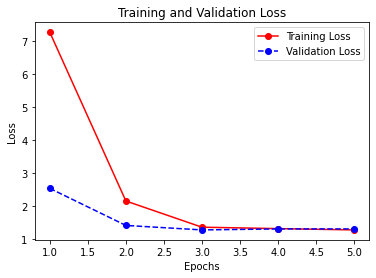

46/46 - 0s - loss: 1.3083 - accuracy: 0.3816


[1.3082621097564697, 0.38163265585899353]

In [14]:
#white wine 기본

white_model = tf.keras.models.Sequential()

white_model.add(layers.Dense(32, activation='relu', input_shape=(11,), name="layer1"))
white_model.add(layers.Dense(10, activation='softmax')) 

white_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
white_model.summary()


white_past = white_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

past_history = white_past.history
loss = past_history['loss']
valid_loss = past_history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro-')
plt.plot(epochs, valid_loss, 'bo--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

white_model.evaluate(x_test, y_test, verbose=2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 32)                384       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 714
Trainable params: 714
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
35/35 [==============================] - 1s 7ms/step - loss: 16.1570 - accuracy: 0.0012 - val_loss: 4.8295 - val_accuracy: 0.2083
Epoch 2/5
35/35 [==============================] - 0s 3ms/step - loss: 3.1755 - accuracy: 0.3205 - val_loss: 1.7350 - val_accuracy: 0.4375
Epoch 3/5
35/35 [==============================] - 0s 3ms/step - loss: 1.8112 - accuracy: 0.4518 - val_loss: 1.5156 - val_accuracy: 0.4812
Epoch 4/5
35/35 [==============================] - 0s 3ms/step - loss: 1.4703 - accuracy: 0.4795 - v

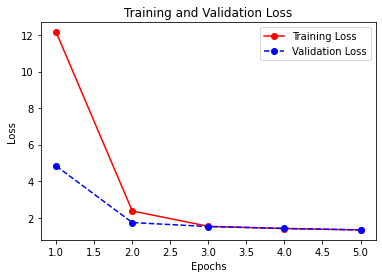

15/15 - 0s - loss: 1.3324 - accuracy: 0.4521


[1.3323639631271362, 0.4520833194255829]

In [16]:
# red_wine 기본

x_train, y_train, x_test, y_test = generate_data(red_wine, 0.7)

red_model = tf.keras.models.Sequential()

red_model.add(layers.Dense(32, activation='relu', input_shape=(11,), name="layer1"))
red_model.add(layers.Dense(10, activation='softmax')) 

red_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
red_model.summary()


red_past = red_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

past_history = red_past.history
loss = past_history['loss']
valid_loss = past_history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro-')
plt.plot(epochs, valid_loss, 'bo--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

red_model.evaluate(x_test, y_test, verbose=2)

### 2. 각 모델의 성능을 향상시킬 수 있는 방법 적용
* 하이퍼파라미터를 변경하여 테스트 셋에서의 정확도를 향상시킬 것
    * 예) 레이어 수, 노드 수, Learning rate 등
* 하이퍼파라미터를 변화시킨 각각의 모델에 대해, 트레이닝 Epoch 당 Loss의 변화를 기록하고 이를 시각화
* 그 외 성능을 향상시킬 수 있는 모든 방법을 사용하여 가장 성능이 좋은 모델을 선택
    * 예) Dropout, Normalization 등

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 32)                384       
_________________________________________________________________
layer2 (Dense)               (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 1,770
Trainable params: 1,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
108/108 [==============================] - 1s 6ms/step - loss: 4.2569 - accuracy: 0.2709 - val_loss: 1.2808 - val_accuracy: 0.4435
Epoch 2/5
108/108 [==============================] - 0s 2ms/step - loss: 1.3367 - accuracy: 0.4452 - val_loss: 1.2263 - val_accuracy: 0.4673
Epoch 3/5
108/108 [==============================] - 0s 2ms/step - loss: 1.2747 - accuracy: 0.4695 -

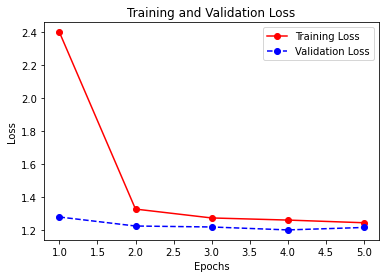

46/46 - 0s - loss: 1.2175 - accuracy: 0.4694


[1.217482328414917, 0.4693877696990967]

In [17]:
# Hidden Layer 개수 바꾸기

x_train, y_train, x_test, y_test = generate_data(white_wine, 0.7)

white_model = tf.keras.models.Sequential()

white_model.add(layers.Dense(32, activation='relu', name="layer1", input_shape=(11,)))
white_model.add(layers.Dense(32, activation='relu', name="layer2"))
white_model.add(layers.Dense(10, activation='softmax')) 

white_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
white_model.summary()


white_past = white_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

past_history = white_past.history
loss = past_history['loss']
valid_loss = past_history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro-')
plt.plot(epochs, valid_loss, 'bo--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()
white_model.evaluate(x_test, y_test, verbose=2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 32)                384       
_________________________________________________________________
layer2 (Dense)               (None, 32)                1056      
_________________________________________________________________
layer3 (Dense)               (None, 32)                1056      
_________________________________________________________________
layer4 (Dense)               (None, 32)                1056      
_________________________________________________________________
layer5 (Dense)               (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total params: 4,938
Trainable params: 4,938
Non-trainable params: 0
____________________________________________________

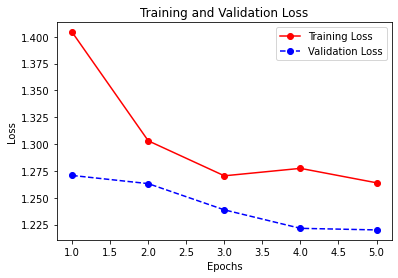

46/46 - 0s - loss: 1.2200 - accuracy: 0.4714


[1.219967246055603, 0.4714285731315613]

In [18]:
# Hidden Layer 개수 바꾸기 2
x_train, y_train, x_test, y_test = generate_data(white_wine, 0.7)

white_model = tf.keras.models.Sequential()

white_model.add(layers.Dense(32, activation='relu', name="layer1", input_shape=(11,)))
white_model.add(layers.Dense(32, activation='relu', name="layer2"))
white_model.add(layers.Dense(32, activation='relu', name="layer3"))
white_model.add(layers.Dense(32, activation='relu', name="layer4"))
white_model.add(layers.Dense(32, activation='relu', name="layer5"))
white_model.add(layers.Dense(10, activation='softmax' )) 

white_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
white_model.summary()


white_past = white_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

past_history = white_past.history
loss = past_history['loss']
valid_loss = past_history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro-')
plt.plot(epochs, valid_loss, 'bo--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()
white_model.evaluate(x_test, y_test, verbose=2)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 64)                768       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 1,418
Trainable params: 1,418
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
108/108 [==============================] - 1s 4ms/step - loss: 14.6531 - accuracy: 0.2724 - val_loss: 1.5804 - val_accuracy: 0.3578
Epoch 2/5
108/108 [==============================] - 0s 2ms/step - loss: 1.5465 - accuracy: 0.3916 - val_loss: 1.6077 - val_accuracy: 0.4109
Epoch 3/5
108/108 [==============================] - 0s 2ms/step - loss: 1.4802 - accuracy: 0.3964 - val_loss: 1.2848 - val_accuracy: 0.4211
Epoch 4/5
108/108 [==============================] - 0s 2ms/step - loss: 1.3579 - accuracy

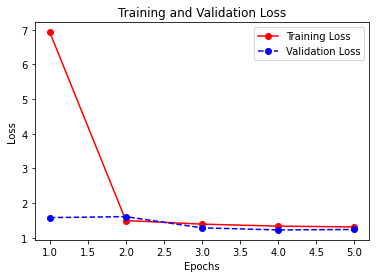

46/46 - 0s - loss: 1.2383 - accuracy: 0.4551


[1.238250494003296, 0.45510202646255493]

In [19]:
#node 갯수 변경

white_model = tf.keras.models.Sequential()

white_model.add(layers.Dense(64, activation='relu', input_shape=(11,), name="layer1"))
white_model.add(layers.Dense(10, activation='softmax')) 

white_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
white_model.summary()


white_past = white_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

past_history = white_past.history
loss = past_history['loss']
valid_loss = past_history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro-')
plt.plot(epochs, valid_loss, 'bo--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

white_model.evaluate(x_test, y_test, verbose=2)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 32)                384       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 714
Trainable params: 714
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
108/108 [==============================] - 1s 3ms/step - loss: 2.2645 - accuracy: 0.2906 - val_loss: 1.4672 - val_accuracy: 0.2980
Epoch 2/5
108/108 [==============================] - 0s 2ms/step - loss: 1.4189 - accuracy: 0.3749 - val_loss: 1.2914 - val_accuracy: 0.4456
Epoch 3/5
108/108 [==============================] - 0s 2ms/step - loss: 1.3093 - accuracy: 0.4471 - val_loss: 1.2690 - val_accuracy: 0.4456
Epoch 4/5
108/108 [==============================] - 0s 2ms/step - loss: 1.3143 - accuracy: 0.4

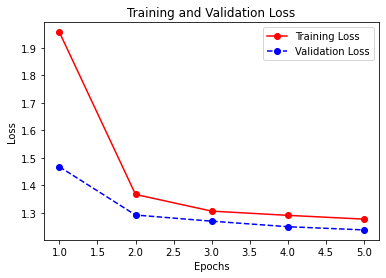

46/46 - 0s - loss: 1.2371 - accuracy: 0.4537


[1.2371424436569214, 0.45374149084091187]

In [20]:
# activation 변경

x_train, y_train, x_test, y_test = generate_data(white_wine, 0.7)

white_model = tf.keras.models.Sequential()

white_model.add(layers.Dense(32, activation='sigmoid', name="layer1", input_shape=(11,)))
white_model.add(layers.Dense(10, activation='softmax')) 


white_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
white_model.summary()


white_past = white_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

past_history = white_past.history
loss = past_history['loss']
valid_loss = past_history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro-')
plt.plot(epochs, valid_loss, 'bo--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()
white_model.evaluate(x_test, y_test, verbose=2)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 32)                384       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                330       
Total params: 842
Trainable params: 778
Non-trainable params: 64
_________________________________________________________________
Epoch 1/5
108/108 [==============================] - 1s 4ms/step - loss: 2.2811 - accuracy: 0.1917 - val_loss: 1.4959 - val_accuracy: 0.3415
Epoch 2/5
108/108 [==============================] - 0s 2ms/step - loss: 1.5291 - accuracy: 0.4428 - val_loss: 1.2963 - val_accuracy: 0.4408
Epoch 3/5
108/108 [==============================] - 0s 3ms/step - loss: 1.3095 - accuracy: 0.4572 - va

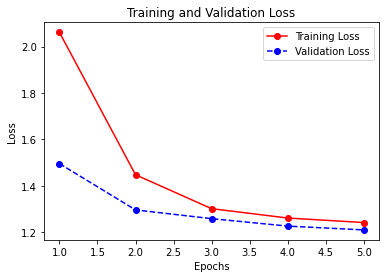

46/46 - 0s - loss: 1.2100 - accuracy: 0.4844


[1.2099863290786743, 0.4843537509441376]

In [21]:
# BatchNormalization 사용

white_model = tf.keras.models.Sequential()

white_model.add(layers.Dense(32, activation='relu', input_shape=(11,), name="layer1"))
white_model.add(BatchNormalization())
white_model.add(layers.Dense(10, activation='softmax')) 

white_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
white_model.summary()


white_past = white_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

past_history = white_past.history
loss = past_history['loss']
valid_loss = past_history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro-')
plt.plot(epochs, valid_loss, 'bo--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

white_model.evaluate(x_test, y_test, verbose=2)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 32)                384       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                330       
Total params: 714
Trainable params: 714
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
108/108 [==============================] - 1s 4ms/step - loss: 21.2771 - accuracy: 0.2679 - val_loss: 4.7848 - val_accuracy: 0.4456
Epoch 2/5
108/108 [==============================] - 0s 2ms/step - loss: 9.3418 - accuracy: 0.3471 - val_loss: 

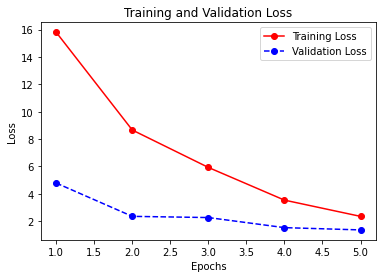

46/46 - 0s - loss: 1.3572 - accuracy: 0.4551


[1.3571624755859375, 0.45510202646255493]

In [22]:
# Dropout 사용

x_train, y_train, x_test, y_test = generate_data(white_wine, 0.7)

white_model = tf.keras.models.Sequential()

white_model.add(layers.Dense(32, activation='relu', name="layer1", input_shape=(11,)))
white_model.add(layers.Dropout(0.2))
white_model.add(layers.Flatten())
white_model.add(layers.Dense(10, activation='softmax')) 

white_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
white_model.summary()


white_past = white_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

past_history = white_past.history
loss = past_history['loss']
valid_loss = past_history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro-')
plt.plot(epochs, valid_loss, 'bo--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()
white_model.evaluate(x_test, y_test, verbose=2)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 64)                768       
_________________________________________________________________
batch_normalization_20 (Batc (None, 64)                256       
_________________________________________________________________
layer2 (Dense)               (None, 64)                4160      
_________________________________________________________________
layer3 (Dense)               (None, 64)                4160      
_________________________________________________________________
layer4 (Dense)               (None, 64)                4160      
_________________________________________________________________
layer5 (Dense)               (None, 64)                4160      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)              

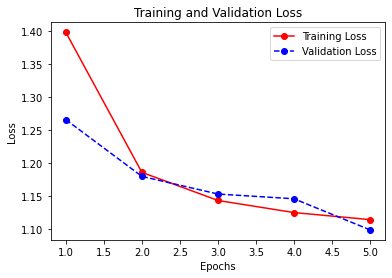

61/61 - 0s - loss: 1.0988 - accuracy: 0.5179


[1.0987906455993652, 0.5179487466812134]

In [48]:
# 최종 개선 white_wine 모델

white_model = tf.keras.models.Sequential()

white_model.add(layers.Dense(64, activation='sigmoid', input_shape=(11,), name="layer1"))
white_model.add(BatchNormalization())
white_model.add(layers.Dense(64, activation='relu', input_shape=(11,), name="layer2"))
#white_model.add(BatchNormalization())
white_model.add(layers.Dense(64, activation='relu', input_shape=(11,), name="layer3"))
white_model.add(layers.Dense(64, activation='relu', input_shape=(11,), name="layer4"))
white_model.add(layers.Dense(64, activation='relu', input_shape=(11,), name="layer5"))
#white_model.add(BatchNormalization())
white_model.add(layers.Dropout(0.2))
white_model.add(layers.Flatten())
#white_model.add(BatchNormalization())

white_model.add(layers.Dense(10, activation='softmax')) 



white_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
white_model.summary()


white_past = white_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

past_history = white_past.history
loss = past_history['loss']
valid_loss = past_history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro-')
plt.plot(epochs, valid_loss, 'bo--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

white_model.evaluate(x_test, y_test, verbose=2)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 64)                768       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
layer2 (Dense)               (None, 64)                4160      
_________________________________________________________________
layer3 (Dense)               (None, 64)                4160      
_________________________________________________________________
layer4 (Dense)               (None, 64)                4160      
_________________________________________________________________
layer5 (Dense)               (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)              

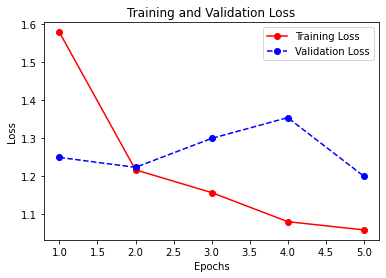

15/15 - 0s - loss: 1.1990 - accuracy: 0.5167


[1.198962926864624, 0.5166666507720947]

In [23]:
# 최종 개선 red_wine 모델

x_train, y_train, x_test, y_test = generate_data(red_wine, 0.7)

red_model = tf.keras.models.Sequential()

red_model.add(layers.Dense(64, activation='sigmoid', input_shape=(11,), name="layer1"))
red_model.add(BatchNormalization())
red_model.add(layers.Dense(64, activation='relu', input_shape=(11,), name="layer2"))
#red_model.add(BatchNormalization())
red_model.add(layers.Dense(64, activation='relu', input_shape=(11,), name="layer3"))
red_model.add(layers.Dense(64, activation='relu', input_shape=(11,), name="layer4"))
red_model.add(layers.Dense(64, activation='relu', input_shape=(11,), name="layer5"))
#red_model.add(BatchNormalization())
red_model.add(layers.Dropout(0.2))
red_model.add(layers.Flatten())
#red_model.add(BatchNormalization())

red_model.add(layers.Dense(10, activation='softmax')) 



red_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
red_model.summary()


red_past = red_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

past_history = red_past.history
loss = past_history['loss']
valid_loss = past_history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro-')
plt.plot(epochs, valid_loss, 'bo--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

red_model.evaluate(x_test, y_test, verbose=2)

### 3. 화이트 와인과 레드 와인을 하나의 모델만 사용하여 분류
* 화이트 와인과 레드 와인 데이터를 합쳐 wine 데이터 셋 생성
* 입력이 화이트 와인인지 레드 와인인지에 관계없이 와인 품질을 분류하는 모델 생성
* 모델의 성능을 향상시킬 수 있는 방법을 찾아 적용할 것


In [27]:
wine = red_wine.append(white_wine)

In [28]:
display(wine)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 32)                384       
_________________________________________________________________
dense_49 (Dense)             (None, 10)                330       
Total params: 714
Trainable params: 714
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
143/143 [==============================] - 1s 3ms/step - loss: 10.8615 - accuracy: 0.2529 - val_loss: 1.6232 - val_accuracy: 0.3544
Epoch 2/5
143/143 [==============================] - 0s 1ms/step - loss: 1.5170 - accuracy: 0.3904 - val_loss: 1.3471 - val_accuracy: 0.3759
Epoch 3/5
143/143 [==============================] - 0s 2ms/step - loss: 1.3484 - accuracy: 0.4091 - val_loss: 1.2898 - val_accuracy: 0.4395
Epoch 4/5
143/143 [==============================] - 0s 2ms/step - loss: 1.3191 - accuracy: 0

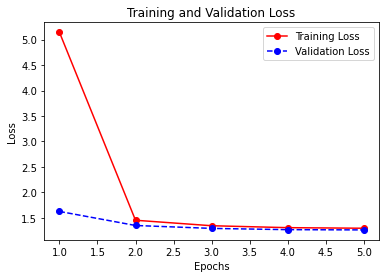

61/61 - 0s - loss: 1.2599 - accuracy: 0.4169


[1.259926438331604, 0.41692307591438293]

In [63]:
# 기본 wine

wine_model = tf.keras.models.Sequential()

wine_model.add(layers.Dense(32, activation='relu', input_shape=(11,), name="layer1"))
wine_model.add(layers.Dense(10, activation='softmax')) 

wine_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
wine_model.summary()


wine_past = wine_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

past_history = wine_past.history
loss = past_history['loss']
valid_loss = past_history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro-')
plt.plot(epochs, valid_loss, 'bo--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

wine_model.evaluate(x_test, y_test, verbose=2)

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 64)                768       
_________________________________________________________________
layer2 (Dense)               (None, 64)                4160      
_________________________________________________________________
layer3 (Dense)               (None, 64)                4160      
_________________________________________________________________
layer4 (Dense)               (None, 64)                4160      
_________________________________________________________________
layer5 (Dense)               (None, 64)                4160      
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 64)              

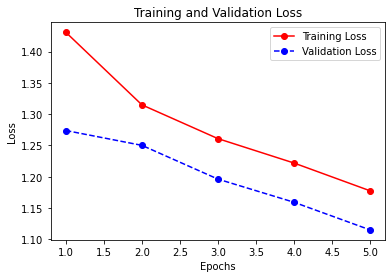

61/61 - 0s - loss: 1.1150 - accuracy: 0.5005


[1.1149663925170898, 0.5005128383636475]

In [70]:
#모델 성능 향상 후 wine

x_train, y_train, x_test, y_test = generate_data(wine, 0.7)

wine_model = tf.keras.models.Sequential()

wine_model.add(layers.Dense(64, activation='sigmoid', input_shape=(11,), name="layer1"))
white_model.add(BatchNormalization())
wine_model.add(layers.Dense(64, activation='relu', input_shape=(11,), name="layer2"))
wine_model.add(layers.Dense(64, activation='relu', input_shape=(11,), name="layer3"))
wine_model.add(layers.Dense(64, activation='relu', input_shape=(11,), name="layer4"))
wine_model.add(layers.Dense(64, activation='relu', input_shape=(11,), name="layer5"))
wine_model.add(layers.Dropout(0.2))
wine_model.add(layers.Flatten())
wine_model.add(layers.Dense(10, activation='softmax')) 



wine_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
wine_model.summary()


wine_past = wine_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

past_history = wine_past.history
loss = past_history['loss']
valid_loss = past_history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro-')
plt.plot(epochs, valid_loss, 'bo--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

wine_model.evaluate(x_test, y_test, verbose=2)